In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

In [12]:
loop7_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_7loopfeats_enhanced.csv"))
loop8_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_8loopfeats_enhanced.csv"))
loop9_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_9loopfeats_enhanced.csv"))

/var/folders/4s/7f5zf8596_526pnhktn077f40000gn/T/ipykernel_4067/900267936.py:3: DtypeWarning: Columns (1,197) have mixed types. Specify dtype option on import or set low_memory=False.
  loop9_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_9loopfeats_enhanced.csv"))


In [3]:
# some intra-loop stuff

In [14]:
loop7_data['COEFFICIENTS'] = (loop7_data['COEFFICIENTS'] .astype(str)!= '0').astype(int)
loop8_data['COEFFICIENTS'] = (loop8_data['COEFFICIENTS'] .astype(str)!= '0').astype(int)
loop9_data['COEFFICIENTS'] = (loop9_data['COEFFICIENTS'] .astype(str)!= '0').astype(int)

In [17]:
loop7_data = loop7_data.replace(np.inf, np.nan)
loop8_data = loop8_data.replace(np.inf, np.nan)
loop9_data = loop9_data.replace(np.inf, np.nan)

/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 1 ROC AUC: 0.908


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 2 ROC AUC: 0.953
Fold 3 ROC AUC: 0.855


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/li

Fold 4 ROC AUC: 0.789


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 5 ROC AUC: 0.933

Average ROC AUC: 0.888 ± 0.059


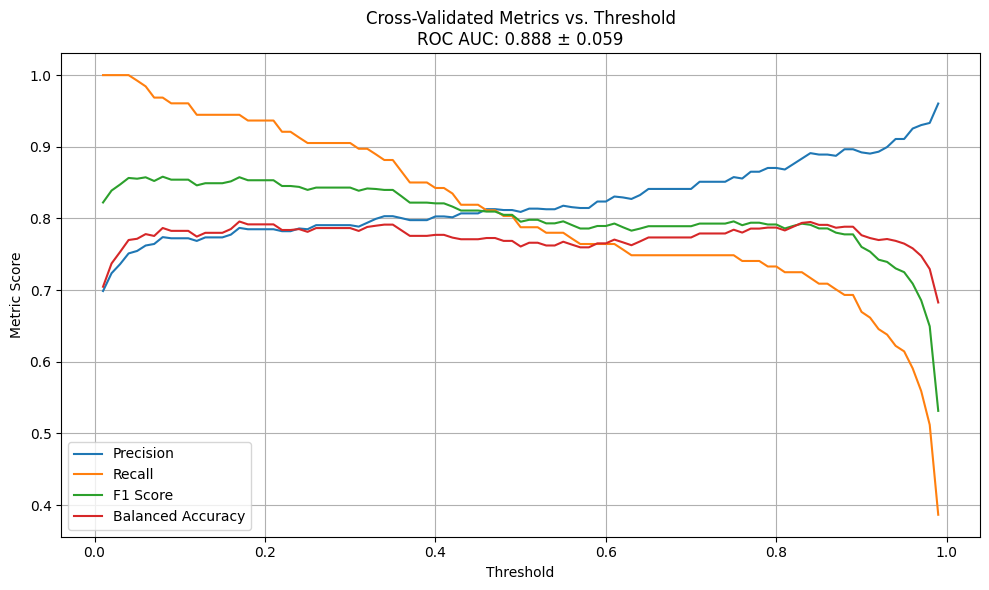

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop7_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC: 0.956
Fold 2 ROC AUC: 0.956
Fold 3 ROC AUC: 0.952
Fold 4 ROC AUC: 0.960
Fold 5 ROC AUC: 0.954

Average ROC AUC: 0.956 ± 0.003


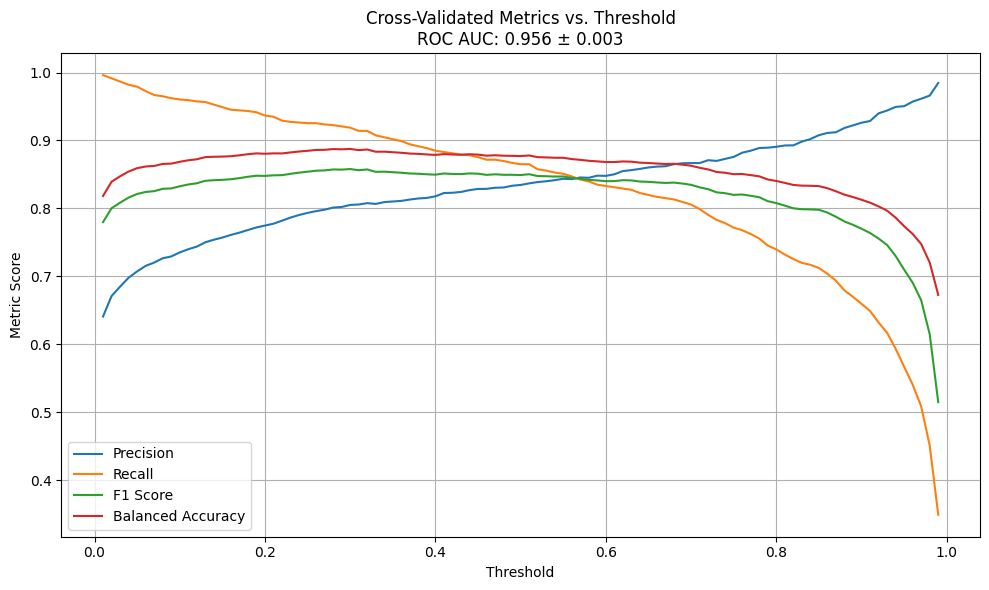

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop8_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC: 0.970
Fold 2 ROC AUC: 0.971
Fold 3 ROC AUC: 0.970
Fold 4 ROC AUC: 0.971
Fold 5 ROC AUC: 0.968

Average ROC AUC: 0.970 ± 0.001


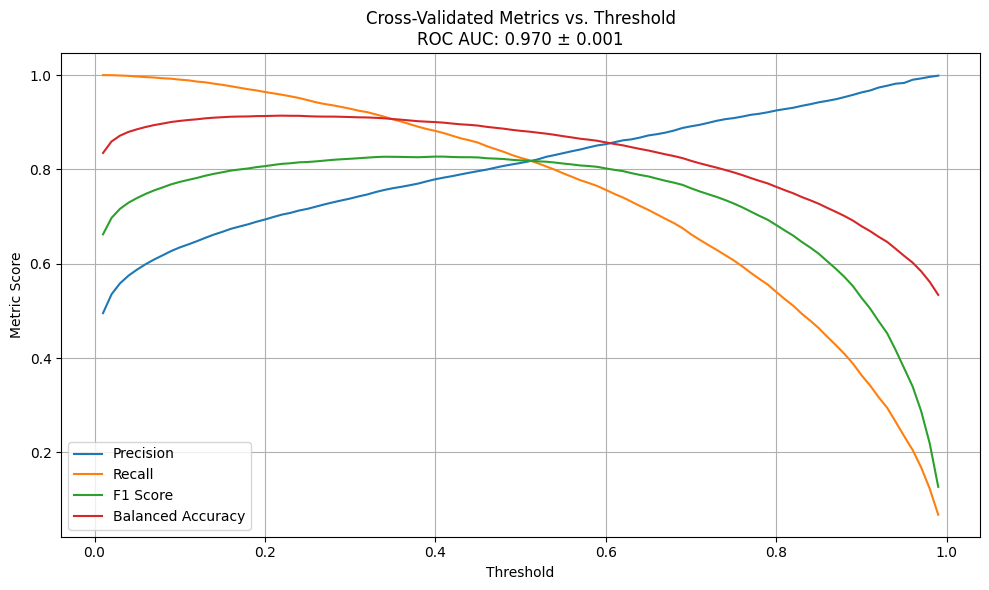

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop9_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop10_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'loop10_data' is not defined

In [21]:
#pairwise stratifications

loop7_data['loops'] = 7
loop8_data['loops'] = 8
loop9_data['loops'] = 9

In [24]:
all_loops = pd.concat([loop7_data, loop8_data, loop9_data], axis = 0)

In [25]:
all_loops['COEFFICIENTS'].unique()

array([1, 0])

In [26]:
all_loops

,Unnamed: 0,COEFFICIENTS,Basic_num_nodes_DEN,Basic_num_edges_DEN,Basic_min_degree_DEN,Basic_max_degree_DEN,Basic_avg_degree_DEN,Basic_degree_std_DEN,Basic_degree_skew_DEN,Basic_density_DEN,...,Cross_K4_mixed,Cross_triangles_mixed_frac,Cross_4cycles_mixed_frac,Cross_diamonds_mixed_frac,Cross_K4_mixed_frac,Cross_triangles_mixed_per_Cn3,Cross_4cycles_mixed_per_Cn4,Cross_diamonds_mixed_per_Cn4,Cross_K4_mixed_per_Cn4,loops
0,0,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,...,8,0.419355,0.666667,0.583333,1.0,0.078788,0.175758,0.084848,0.024242,7
1,1,0,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,...,6,0.379310,0.677778,0.551020,1.0,0.066667,0.184848,0.081818,0.018182,7
2,2,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,...,9,0.419355,0.674157,0.558140,1.0,0.078788,0.181818,0.072727,0.027273,7
3,3,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,...,6,0.379310,0.681319,0.562500,1.0,0.066667,0.187879,0.081818,0.018182,7
4,4,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,...,7,0.419355,0.662791,0.615385,1.0,0.078788,0.172727,0.096970,0.021212,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43012,43012,0,13,32,4,6,4.923077,0.916644,0.152471,0.410256,...,11,0.382353,0.515789,0.460000,1.0,0.045455,0.068531,0.032168,0.015385,9
43013,43013,0,13,30,4,6,4.615385,0.923077,0.833333,0.384615,...,5,0.230769,0.315789,0.222222,1.0,0.020979,0.025175,0.011189,0.006993,9
43014,43014,0,13,28,4,5,4.307692,0.461538,0.833333,0.358974,...,0,0.100000,0.128205,0.125000,NaN,0.006993,0.006993,0.005594,0.000000,9
43015,43015,0,13,33,4,7,5.076923,1.071414,0.222049,0.423077,...,20,0.414634,0.508772,0.450980,1.0,0.059441,0.081119,0.032168,0.027972,9


Fold 1 ROC AUC (loop 7): 0.693
Fold 1 ROC AUC (loop 8): 0.713
Fold 2 ROC AUC (loop 7): 0.729
Fold 2 ROC AUC (loop 8): 0.734
Fold 3 ROC AUC (loop 7): 0.659
Fold 3 ROC AUC (loop 8): 0.740
Fold 4 ROC AUC (loop 7): 0.644
Fold 4 ROC AUC (loop 8): 0.724
Fold 5 ROC AUC (loop 7): 0.743
Fold 5 ROC AUC (loop 8): 0.748

Average ROC AUC for loop 7: 0.694 ± 0.038
Average ROC AUC for loop 8: 0.732 ± 0.012


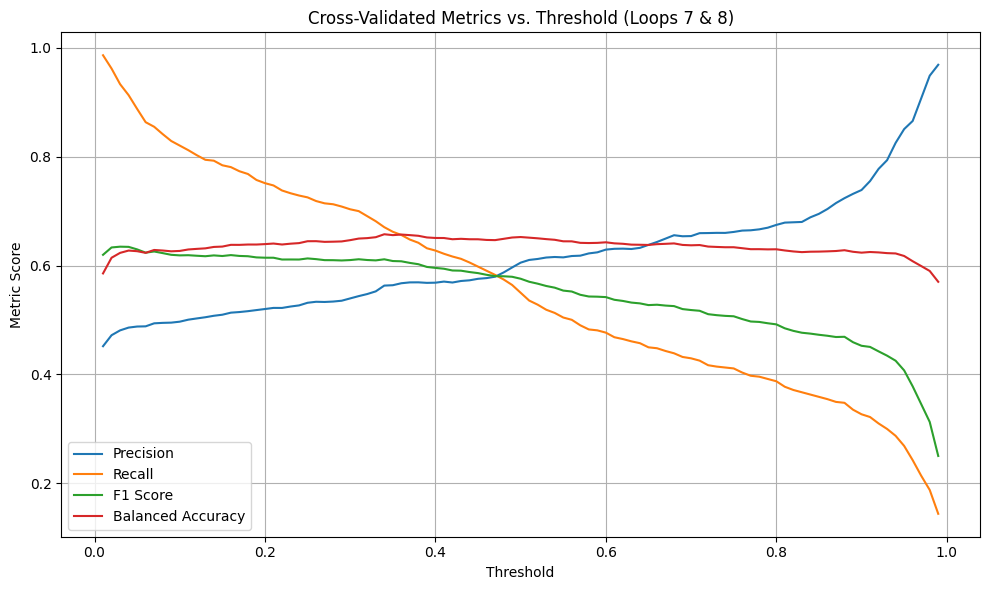

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([7, 8])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop7_aucs = []
loop8_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(7, loop7_aucs), (8, loop8_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 7: {np.mean(loop7_aucs):.3f} ± {np.std(loop7_aucs):.3f}")
print(f"Average ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 7 & 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 8): 0.768
Fold 1 ROC AUC (loop 9): 0.781
Fold 2 ROC AUC (loop 8): 0.799
Fold 2 ROC AUC (loop 9): 0.792
Fold 3 ROC AUC (loop 8): 0.748
Fold 3 ROC AUC (loop 9): 0.784
Fold 4 ROC AUC (loop 8): 0.746
Fold 4 ROC AUC (loop 9): 0.785
Fold 5 ROC AUC (loop 8): 0.786
Fold 5 ROC AUC (loop 9): 0.794

Average ROC AUC for loop 8: 0.770 ± 0.021
Average ROC AUC for loop 9: 0.787 ± 0.005


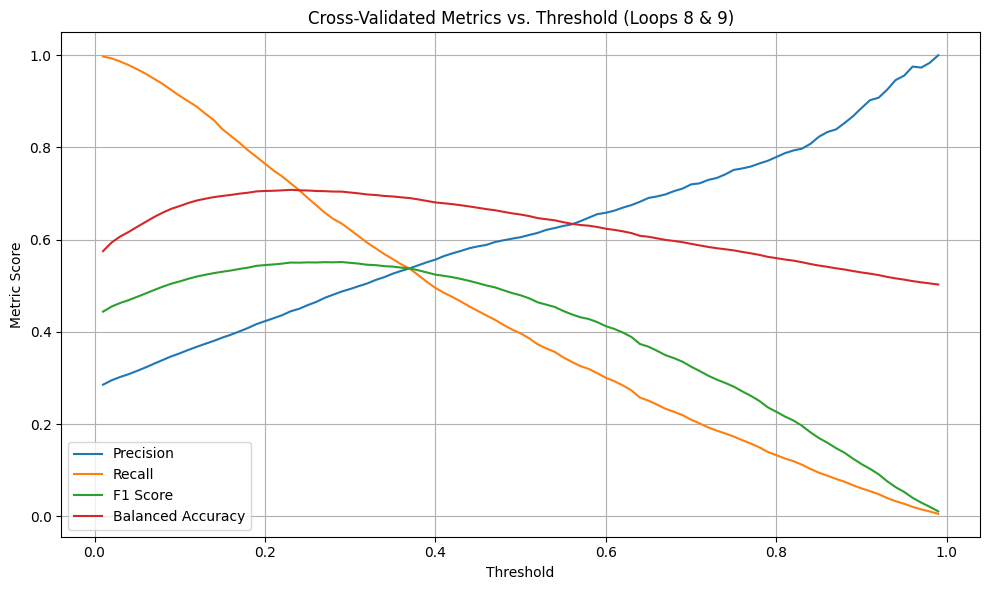

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([8,9])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(8, loop8_aucs), (9, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 9: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 8 & 9)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 8): 0.715
Fold 1 has no samples for loop 10
Fold 2 ROC AUC (loop 8): 0.759
Fold 2 has no samples for loop 10
Fold 3 ROC AUC (loop 8): 0.718
Fold 3 has no samples for loop 10
Fold 4 ROC AUC (loop 8): 0.714
Fold 4 has no samples for loop 10
Fold 5 ROC AUC (loop 8): 0.747
Fold 5 has no samples for loop 10

Average ROC AUC for loop 8: 0.731 ± 0.019
Average ROC AUC for loop 10: nan ± nan


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


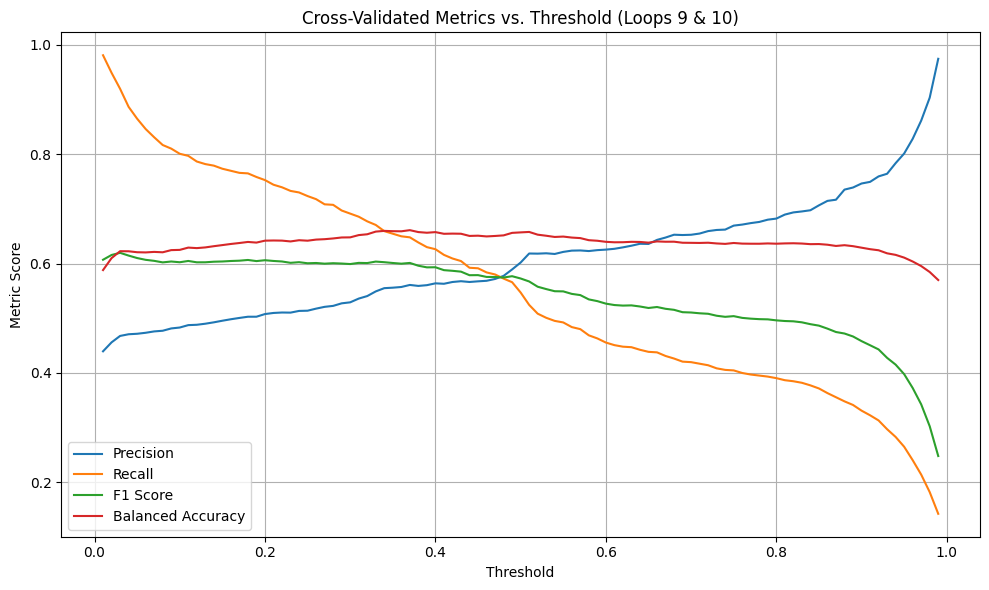

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([8,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(8, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([8,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(8, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 7): 0.616
Fold 1 ROC AUC (loop 9): 0.780
Fold 2 ROC AUC (loop 7): 0.739
Fold 2 ROC AUC (loop 9): 0.795
Fold 3 ROC AUC (loop 7): 0.648
Fold 3 ROC AUC (loop 9): 0.789
Fold 4 ROC AUC (loop 7): 0.606
Fold 4 ROC AUC (loop 9): 0.777
Fold 5 ROC AUC (loop 7): 0.701
Fold 5 ROC AUC (loop 9): 0.777

Average ROC AUC for loop 7: 0.662 ± 0.051
Average ROC AUC for loop 9: 0.784 ± 0.007


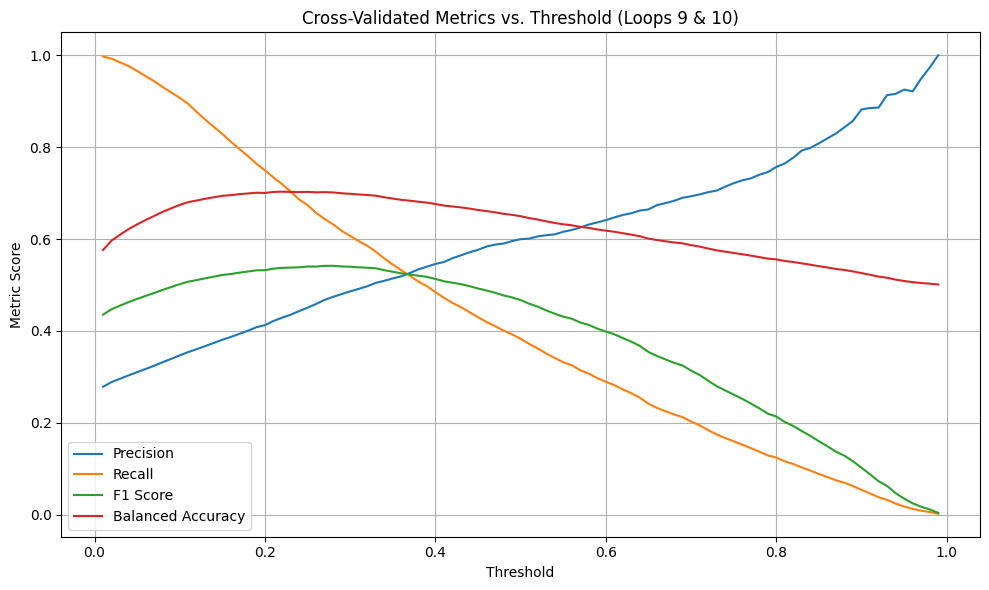

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([7,9])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(7, loop8_aucs), (9, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 7: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 9: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
# directionality

Fold 1 AUC (train folds on loops [7]): 0.663
Fold 1 AUC (loop 8): 0.694
Fold 1 AUC (loop 9): 0.657
Fold 2 AUC (train folds on loops [7]): 0.660
Fold 2 AUC (loop 8): 0.662
Fold 2 AUC (loop 9): 0.661
Fold 3 AUC (train folds on loops [7]): 0.611
Fold 3 AUC (loop 8): 0.686
Fold 3 AUC (loop 9): 0.676
Fold 4 AUC (train folds on loops [7]): 0.556
Fold 4 AUC (loop 8): 0.671
Fold 4 AUC (loop 9): 0.677
Fold 5 AUC (train folds on loops [7]): 0.680
Fold 5 AUC (loop 8): 0.657
Fold 5 AUC (loop 9): 0.644

Average ROC AUC on training fold (loops [7]): 0.634 ± 0.045
Average ROC AUC on loop 8: 0.674 ± 0.014
Average ROC AUC on loop 9: 0.663 ± 0.012


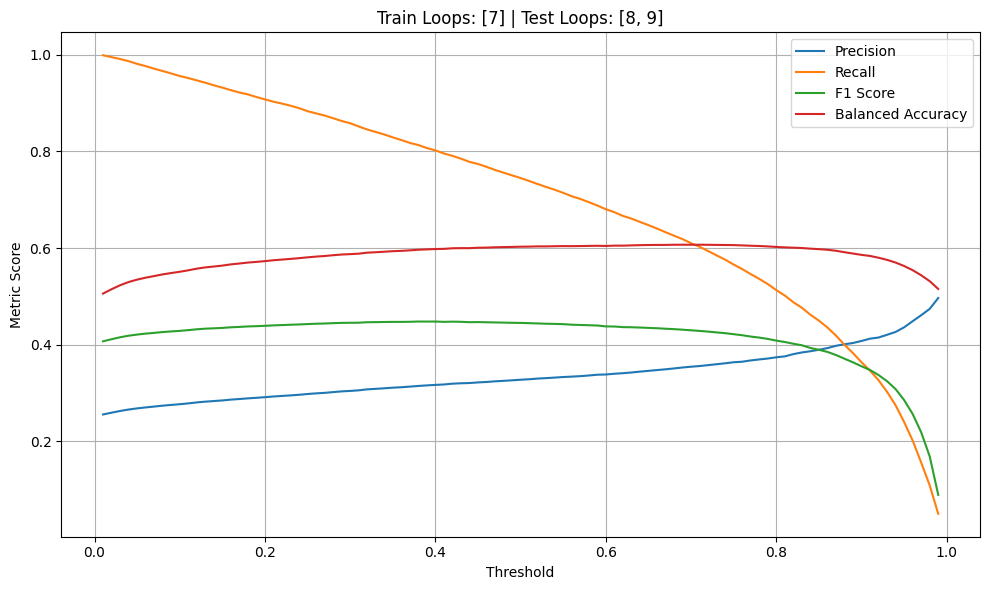

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7]
test_loops = [8, 9]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'

# --- Train data ---
X_train_full = train_data[data_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test = test_data[data_cols].values
y_test = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Thresholds for metric curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- AUC trackers ---
train_val_aucs = []  # loop(s) used for training cross-val
test_loop_aucs = {loop: [] for loop in test_loops}  # aucs for each test loop

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    # --- AUC on validation set (from train loop group) ---
    val_scores = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_scores)
    train_val_aucs.append(val_auc)
    print(f"Fold {fold+1} AUC (train folds on loops {train_loops}): {val_auc:.3f}")

    # --- AUC on each test loop
    test_scores = model.predict_proba(X_test)[:, 1]
    for loop_id in test_loops:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], test_scores[mask])
            test_loop_aucs[loop_id].append(auc)
            print(f"Fold {fold+1} AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold metrics (on all test loops combined) ---
    for i, t in enumerate(thresholds):
        y_pred = (test_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Print AUC summaries ---
print(f"\nAverage ROC AUC on training fold (loops {train_loops}): {np.mean(train_val_aucs):.3f} ± {np.std(train_val_aucs):.3f}")
for loop_id in test_loops:
    aucs = test_loop_aucs[loop_id]
    print(f"Average ROC AUC on loop {loop_id}: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 AUC (train folds on loops [7, 8]): 0.692
Fold 1 AUC (loop 9): 0.724
Fold 2 AUC (train folds on loops [7, 8]): 0.722
Fold 2 AUC (loop 9): 0.733
Fold 3 AUC (train folds on loops [7, 8]): 0.752
Fold 3 AUC (loop 9): 0.727
Fold 4 AUC (train folds on loops [7, 8]): 0.735
Fold 4 AUC (loop 9): 0.717
Fold 5 AUC (train folds on loops [7, 8]): 0.742
Fold 5 AUC (loop 9): 0.711

Average ROC AUC on training fold (loops [7, 8]): 0.728 ± 0.021
Average ROC AUC on loop 9: 0.722 ± 0.007


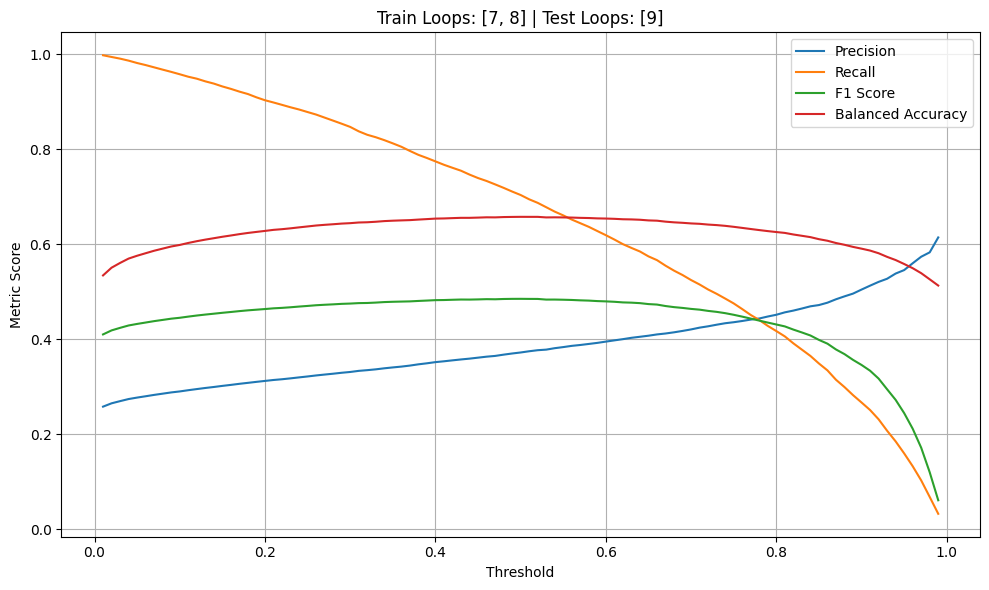

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7,8]
test_loops = [9]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'

# --- Train data ---
X_train_full = train_data[data_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test = test_data[data_cols].values
y_test = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Thresholds for metric curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- AUC trackers ---
train_val_aucs = []  # loop(s) used for training cross-val
test_loop_aucs = {loop: [] for loop in test_loops}  # aucs for each test loop

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    # --- AUC on validation set (from train loop group) ---
    val_scores = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_scores)
    train_val_aucs.append(val_auc)
    print(f"Fold {fold+1} AUC (train folds on loops {train_loops}): {val_auc:.3f}")

    # --- AUC on each test loop
    test_scores = model.predict_proba(X_test)[:, 1]
    for loop_id in test_loops:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], test_scores[mask])
            test_loop_aucs[loop_id].append(auc)
            print(f"Fold {fold+1} AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold metrics (on all test loops combined) ---
    for i, t in enumerate(thresholds):
        y_pred = (test_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Print AUC summaries ---
print(f"\nAverage ROC AUC on training fold (loops {train_loops}): {np.mean(train_val_aucs):.3f} ± {np.std(train_val_aucs):.3f}")
for loop_id in test_loops:
    aucs = test_loop_aucs[loop_id]
    print(f"Average ROC AUC on loop {loop_id}: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
##### STOP HERE


from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# --- Fixed test loop ---
TEST_LOOP = 9

# --- Candidate train loops ---
CANDIDATE_LOOPS = [7, 8, 9]

# --- Columns ---
target_col   = 'COEFFICIENTS'
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Pre-slice test data once ---
test_data = all_loops[all_loops['loops'] == TEST_LOOP]
if test_data.empty:
    raise ValueError(f"No samples for test loop {TEST_LOOP}.")

X_test = test_data[feature_cols].values
y_test = test_data[target_col].values.ravel()

results = []
train_loop_perf_rows = []

# iterate over all non-empty combinations of candidate train loops
for r in range(1, len(CANDIDATE_LOOPS) + 1):
    for train_loops in combinations(CANDIDATE_LOOPS, r):
        train_data = all_loops[all_loops['loops'].isin(train_loops)]
        if train_data.empty:
            continue

        y_train = train_data[target_col].values.ravel()
        if len(np.unique(y_train)) < 2:
            # cannot train a classifier on a single class
            continue

        X_train = train_data[feature_cols].values

        # --- Train model on this combo ---
        model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
        model.fit(X_train, y_train)

        # --- Train AUC (overall on all training rows) ---
        train_scores_all = model.predict_proba(X_train)[:, 1]
        train_auc_all = roc_auc_score(y_train, train_scores_all)

        # --- Per-loop AUCs within training set ---
        for loop_id in train_loops:
            loop_mask = (train_data['loops'].values == loop_id)
            y_loop = y_train[loop_mask]
            # handle single-class slices safely
            if len(np.unique(y_loop)) < 2:
                loop_auc = np.nan
            else:
                loop_scores = train_scores_all[loop_mask]
                loop_auc = roc_auc_score(y_loop, loop_scores)

            train_loop_perf_rows.append({
                "train_loops": tuple(train_loops),
                "loop_id": loop_id,
                "n_train_loop": int(loop_mask.sum()),
                "train_auc_loop": loop_auc
            })

        # --- Test AUC on loop 11 ---
        test_scores = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, test_scores)

        results.append({
            "train_loops": tuple(train_loops),
            "n_train": len(train_data),
            "train_auc_overall": train_auc_all,
            "test_loop": TEST_LOOP,
            "test_auc": test_auc
        })

# --- Summaries ---
results_df = pd.DataFrame(results).sort_values(by=["test_auc", "train_auc_overall"], ascending=False)

train_loop_perf_df = pd.DataFrame(train_loop_perf_rows)
# (optional) pivot to wide format if you prefer one row per combo:
# wide_train_loop_perf = train_loop_perf_df.pivot(index="train_loops", columns="loop_id", values="train_auc_loop")

print("=== Overall by combo ===")
print(results_df.to_string(index=False))

print("\n=== Training per-loop AUCs (long-form) ===")
print(train_loop_perf_df.sort_values(["train_loops","loop_id"]).to_string(index=False))


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:47:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_

=== Overall by combo ===
train_loops  n_train  train_auc_overall  test_loop  test_auc
     (7, 9)    43237           0.998275          9  0.998251
       (9,)    43017           0.998227          9  0.998227
  (7, 8, 9)    45946           0.998309          9  0.998167
     (8, 9)    45726           0.998056          9  0.997913
     (7, 8)     2929           1.000000          9  0.879266
       (8,)     2709           1.000000          9  0.871598
       (7,)      220           1.000000          9  0.783201

=== Training per-loop AUCs (long-form) ===
train_loops  loop_id  n_train_loop  train_auc_loop
       (7,)        7           220        1.000000
     (7, 8)        7           220        1.000000
     (7, 8)        8          2709        1.000000
  (7, 8, 9)        7           220        1.000000
  (7, 8, 9)        8          2709        0.999547
  (7, 8, 9)        9         43017        0.998167
     (7, 9)        7           220        1.000000
     (7, 9)        9         43017 

In [45]:
# cluster the data and let's see what preditive power we get

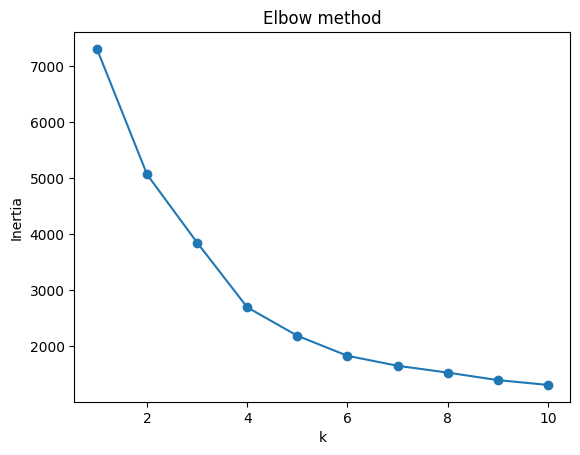

Suggested k = 2


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 7]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


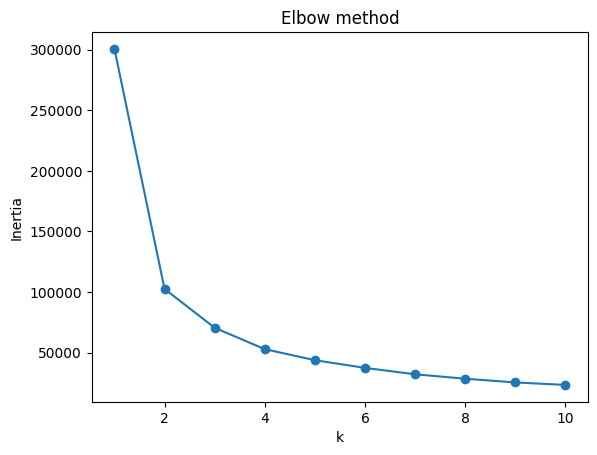

Suggested k = 2


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 8]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


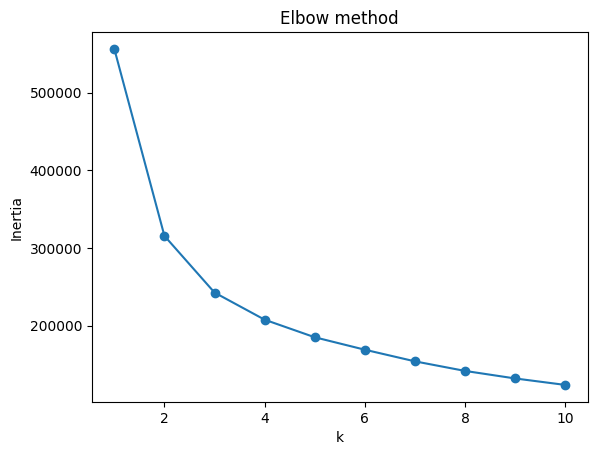

Suggested k = 2


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 9]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


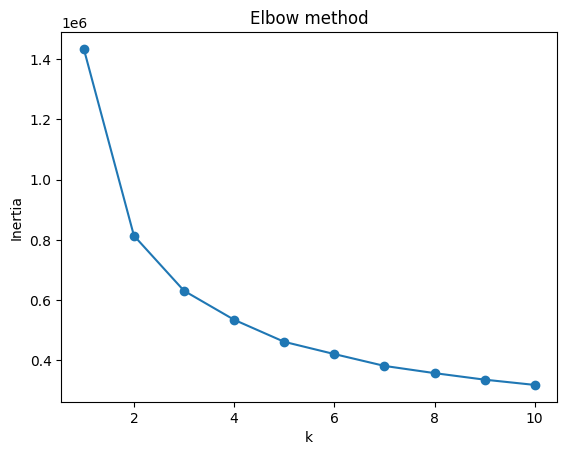

Suggested k = 2


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 9]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


In [49]:
# let's take 20

In [52]:
test_df

,COEFFICIENTS,Basic_num_nodes,Basic_num_edges,Basic_min_degree,Basic_max_degree,Basic_avg_degree,Basic_degree_std,Basic_degree_skew,Basic_density,Basic_edge_to_node_ratio,...,Spectral_lap_eig_8,Spectral_lap_eig_9,Kirchhoff_index,Planarity_num_faces,Planarity_face_size_mean,Planarity_face_size_max,Symmetry_automorphism_group_order,Symmetry_num_orbits,Symmetry_orbit_size_max,loops
0,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,2.454545,...,6.732051,7.145103,23.571138,18,3.000000,3,4,5,4,7
1,0,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,2.454545,...,6.732051,7.145103,23.571138,18,3.000000,3,4,5,4,7
2,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,2.454545,...,6.732051,7.145103,23.571138,18,3.000000,3,4,5,4,7
3,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,2.454545,...,6.732051,7.145103,23.571138,18,3.000000,3,4,5,4,7
4,1,11,27,4,6,4.909091,0.514259,-0.132583,0.490909,2.454545,...,6.732051,7.145103,23.571138,18,3.000000,3,4,5,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45941,0,13,32,4,6,4.923077,0.916644,0.152471,0.410256,2.461538,...,6.209057,6.210717,39.773890,21,3.047619,4,2,9,2,9
45942,0,13,30,4,6,4.615385,0.923077,0.833333,0.384615,2.307692,...,5.254102,6.618034,49.014368,19,3.157895,4,16,4,4,9
45943,0,13,28,4,5,4.307692,0.461538,0.833333,0.358974,2.153846,...,5.254102,6.230725,75.612069,17,3.294118,7,32,4,4,9
45944,0,13,33,4,7,5.076923,1.071414,0.222049,0.423077,2.538462,...,6.519120,6.936457,38.560318,22,3.000000,3,2,9,2,9


In [51]:
"""
Goal
----
Find which cluster (from the ten test loops) you should add to the
training data to maximise performance on the rest of the test set.
"""

import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------
train_loops  = [7, 8]          # original train loops
test_loops   = list(range(1, 10)) # ten loops → will be clustered
random_state = 42
n_splits     = 5
n_clusters   = 20                 # exactly 10 clusters on the test set
# ------------------------------------------------------------

# ------------------  split data -----------------------------
train_df = all_loops[all_loops["loops"].isin(train_loops)].reset_index(drop=True)
test_df  = all_loops[all_loops["loops"].isin(test_loops )].reset_index(drop=True)

feature_cols = [c for c in all_loops.columns if c not in ("COEFFICIENTS", "loops")]
target_col   = "COEFFICIENTS"

X_train_base = train_df[feature_cols].values
y_train_base = train_df[target_col].values.ravel()

X_test_df    = test_df[feature_cols].copy()      # keep NaNs for XGB
y_test_full  = test_df[target_col].values.ravel()
loops_full   = test_df["loops"].values

# ------------------  cluster test set ----------------------
X_cluster = X_test_df.dropna(axis=1).values      # drop NaN columns for KMeans
kmeans    = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
clusters  = kmeans.fit_predict(X_cluster)

# ------------------  function: train & score ---------------
def train_and_score(X_train, y_train, X_test, y_test):
    """
    Train a fresh XGB (single fit, no CV) and return ROC-AUC on X_test.
    """
    model = XGBClassifier(eval_metric="logloss", random_state=random_state)
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    auc  = roc_auc_score(y_test, prob)
    return auc, prob

# ---------- main experiment (unchanged except for bookkeeping) ----------
results = []

for cl in range(n_clusters):
    in_clust  = clusters == cl
    out_clust = ~in_clust

    X_train = np.vstack([X_train_base, X_test_df[in_clust].values])
    y_train = np.concatenate([y_train_base, y_test_full[in_clust]])

    X_test  = X_test_df[out_clust].values
    y_test  = y_test_full[out_clust]
    loops   = loops_full[out_clust]

    auc, prob = train_and_score(X_train, y_train, X_test, y_test)

    results.append(
        dict(cluster=cl,
             added_rows=in_clust.sum(),
             remaining_rows=out_clust.sum(),
             final_train_rows=X_train.shape[0],
             final_test_rows=X_test.shape[0],
             overall_auc=auc,
             auc_by_loop={
                 lp: roc_auc_score(y_test[loops == lp], prob[loops == lp])
                 for lp in np.unique(loops)
             })
    )

# ------------------  report -------------------------------
print("\n=== PROMOTE-ONE-CLUSTER RESULTS ===")
for r in results:
    print(f"Cluster {r['cluster']:2d} | "
          f"rows→train {r['added_rows']:5d} | "
          f"remaining test {r['remaining_rows']:5d} | "
          f"AUC = {r['overall_auc']:.3f}")

best = max(results, key=lambda r: r["overall_auc"])

print(f"\n>>> Add cluster {best['cluster']} "
      f"→ best AUC {best['overall_auc']:.3f}")
print(f"Final TRAIN size = {best['final_train_rows']} rows")
print(f"Final TEST  size = {best['final_test_rows']} rows")

print("\nPer-loop AUC after adding that cluster:")
for lp, score in sorted(best["auc_by_loop"].items()):
    print(f"  Loop {lp:2d} · AUC = {score:.3f}")


=== PROMOTE-ONE-CLUSTER RESULTS ===
Cluster  0 | rows→train  4512 | remaining test 41434 | AUC = 0.757
Cluster  1 | rows→train  3072 | remaining test 42874 | AUC = 0.759
Cluster  2 | rows→train   775 | remaining test 45171 | AUC = 0.744
Cluster  3 | rows→train   220 | remaining test 45726 | AUC = 0.755
Cluster  4 | rows→train  5018 | remaining test 40928 | AUC = 0.769
Cluster  5 | rows→train   669 | remaining test 45277 | AUC = 0.756
Cluster  6 | rows→train    14 | remaining test 45932 | AUC = 0.749
Cluster  7 | rows→train  2022 | remaining test 43924 | AUC = 0.773
Cluster  8 | rows→train   845 | remaining test 45101 | AUC = 0.743
Cluster  9 | rows→train  4019 | remaining test 41927 | AUC = 0.760
Cluster 10 | rows→train   819 | remaining test 45127 | AUC = 0.761
Cluster 11 | rows→train  5027 | remaining test 40919 | AUC = 0.765
Cluster 12 | rows→train  3513 | remaining test 42433 | AUC = 0.766
Cluster 13 | rows→train     8 | remaining test 45938 | AUC = 0.751
Cluster 14 | rows→train  

In [53]:
# ------------------------------------------------------------
# 1️⃣  First pass (unchanged) – pick the single best cluster
# ------------------------------------------------------------
first_pass = []

for cl in range(n_clusters):
    mask_in  = clusters == cl
    mask_out = ~mask_in

    X_train = np.vstack([X_train_base, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_base, y_test_full[mask_in]])

    auc, _  = train_and_score(X_train, y_train,
                              X_test_df[mask_out].values,
                              y_test_full[mask_out])

    first_pass.append((cl, auc))

best1, best1_auc = max(first_pass, key=lambda t: t[1])
print(f"▶ Best first cluster = {best1}  (AUC = {best1_auc:.3f})")

# ------------------------------------------------------------
# 2️⃣  Second pass – pick the best *additional* cluster
# ------------------------------------------------------------
mask_best1 = clusters == best1          # already promoted
X_train_lvl1 = np.vstack([X_train_base,
                          X_test_df[mask_best1].values])
y_train_lvl1 = np.concatenate([y_train_base,
                               y_test_full[mask_best1]])

second_pass = []

for cl in range(n_clusters):
    if cl == best1:
        continue                       # skip the one we already added

    mask_in  = (clusters == cl)
    mask_out = ~(mask_best1 | mask_in) # still-held-out data

    X_train = np.vstack([X_train_lvl1, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_lvl1, y_test_full[mask_in]])

    auc, _ = train_and_score(X_train, y_train,
                             X_test_df[mask_out].values,
                             y_test_full[mask_out])

    second_pass.append((cl, auc))

best2, best2_auc = max(second_pass, key=lambda t: t[1])

print("\n=== TWO-CLUSTER PROMOTION RESULT ===")
print(f"1st cluster promoted : {best1}")
print(f"2nd cluster promoted : {best2}")
print(f"AUC after two clusters: {best2_auc:.3f}")


▶ Best first cluster = 15  (AUC = 0.774)

=== TWO-CLUSTER PROMOTION RESULT ===
1st cluster promoted : 15
2nd cluster promoted : 16
AUC after two clusters: 0.790


In [54]:
# ------------------------------------------------------------
# Utility: return overall AUC after promoting a given set of clusters
# ------------------------------------------------------------
def auc_with_clusters(promoted):
    """
    promoted : iterable of cluster IDs already moved to the train fold
    """
    promoted_mask = np.isin(clusters, promoted)

    X_train = np.vstack([X_train_base, X_test_df[promoted_mask].values])
    y_train = np.concatenate([y_train_base, y_test_full[promoted_mask]])

    X_hold  = X_test_df[~promoted_mask].values
    y_hold  = y_test_full[~promoted_mask]

    auc, _ = train_and_score(X_train, y_train, X_hold, y_hold)
    return auc

# ------------------------------------------------------------
# We already have best1 and best2 from the earlier passes
# ------------------------------------------------------------
selected = [best1, best2]
current_auc = auc_with_clusters(selected)
print(f"AUC after clusters {selected}: {current_auc:.3f}")

# ------------------------------------------------------------
# 3️⃣  Third pass – pick the next best cluster
# ------------------------------------------------------------
candidates = [c for c in range(n_clusters) if c not in selected]

improvements = []
for c in candidates:
    auc_c = auc_with_clusters(selected + [c])
    improvements.append((c, auc_c))

best3, best3_auc = max(improvements, key=lambda t: t[1])
selected.append(best3)

print("\n=== THREE-CLUSTER PROMOTION RESULT ===")
print(f"Clusters promoted : {selected}")
print(f"AUC after three clusters: {best3_auc:.3f}")


AUC after clusters [15, 16]: 0.790

=== THREE-CLUSTER PROMOTION RESULT ===
Clusters promoted : [15, 16, 12]
AUC after three clusters: 0.802


In [59]:
np.sum([c in [15, 16] for c in clusters])

np.int64(8263)

In [60]:
(all_loops[all_loops['loops'] == 9].shape[0]/5)*4

34413.6

In [62]:
#loops 7,8,9 and lesser parts of 10 would be helpful in scoring 10 better than others.

In [63]:
# what coefficients of 10 are hard to find using cusp relation or switch when using each method?

In [64]:
pd.Series(clusters).value_counts().sort_index()

0     4512
1     3072
2      775
3      220
4     5018
5      669
6       14
7     2022
8      845
9     4019
10     819
11    5027
12    3513
13       8
14    1041
15    5681
16    2582
17    1244
18    1422
19    3443
Name: count, dtype: int64